# Stochastic Gradient Descent

Before we start to talk about the SGD, first we need to have a rough idea about Gradient Descent. Here is a sample code for Gradient Descent.

In [1]:
import numpy as np

# generate data
np.random.seed(42)
X = 2 * np.random.rand(100, 10)
y = 4 + 3 * X.dot(np.random.randn(10, 1)) + np.random.randn(100, 1)

# init
theta = np.random.randn(11, 1)

# adding intercept
X_b = np.c_[np.ones((100, 1)), X]

learning_rate = 0.1
num_iterations = 1000

for iteration in range(num_iterations):

    y_pred = X_b.dot(theta)
    
    # calculate loss
    loss = np.mean((y_pred - y)**2)
    
    # calculate gradient
    gradient = 2 * X_b.T.dot(y_pred - y) / len(y)
    
    # update parameter
    theta = theta - learning_rate * gradient

# 输出最终优化的模型参数
print("Optimized parameters:", theta)

Optimized parameters: [[-4.12341880e+75]
 [-3.88876855e+75]
 [-4.76192661e+75]
 [-3.87814045e+75]
 [-4.31970070e+75]
 [-3.81708271e+75]
 [-4.50407650e+75]
 [-3.94387939e+75]
 [-4.28411920e+75]
 [-4.33983404e+75]
 [-3.97085642e+75]]


We can see that the calculation is related to all 10 features. When the number of features go up, the speed of calculation will be incredibly slow. Thus, SGD is created to solve these kind of problem.

## Basic Idea

The basic idea of SGD is randomly choosing one feature for each iteration and use the gradient of that feature to substitute the gradient of all features. This means that the calculation speed will be n times faster for n features.

## Math Proof

Instead of providing strict math proof, I will only provide some qualitative analysis limited by my poor math ability.

Here is a illustration of gradient descent algorithm with different iteration step. As we can see, when the iteration step is small, the optimization goes nice and smooth. However, when the iteration step becomes large, the curve goes wildly.

![gds](../../../src/gd_s.png)

![gdl](../../../src/gd_l.png)

For SGD algorithm, the model is far more sensitive to the iteration step. When iteration step becomes large, the fluctuation will become much bigger.

![sgds](../../../src/sgd_s.png)

![sgdl](../../../src/sgd_l.png)

One of important pattern of SGD is that the curve is smooth at beginning which is similar to the gradient descent. However, the fluctuation will appear when curve is close to the optimal target. This pattern will help us prevent overfit and make the mdoel more robust to the noise in the perspective of machine learning. The reason for the confusion can be illustrated by dropping a graph. Suppose we take least square as the loss function, the minimum of one feature is reached when it is equal to $\frac{a_i}{b_i}$. Thus we get the figure.

![fluctuation](../../../src/fluct_reason.jpg)

The final solution should lay in the maximum and minimum of these numbers (this can be proved by math). Therefore, when the curve is far from the target, it will go smooth, however, when it approach the target, fluctuation will happen.

Moreover, the SGD algorithm is an unbiased estimation of the true gradient.

A similar way to improve the gradient descent problem is the mini-batch strategy, which divide the data set into several small batch which balances the SGD and gradient descent.

---

## Advantage and Disadvantage

- Advantage
    - Efficiency.
    - Ease of implementation (lots of opportunities for code tuning).
- Disadvantage
  - SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
  - SGD is sensitive to feature scaling.

### Warning and Reason

Make sure you permute (shuffle) your training data before fitting the model or use shuffle=True to shuffle after each iteration (used by default). Also, ideally, features should be standardized using e.g. make_pipeline(StandardScaler(), SGDClassifier())

The reason for us to shuffle the data everytime after each iteration is that different from the mathematical proof, see in [user guide](https://scikit-learn.org/stable/modules/sgd.html), in the actual world the data are highly possible from different distribution and thus we have to shuffle the data to solve this problem. (for more detailed explanation, you should search for IID probability problem, which is still not solved completely nowadays)

## First SGD Model

Here is a simple illustration for implementing the SGD with sklearn.

In [2]:
from sklearn.linear_model import SGDClassifier
X = [[0., 0.], [1., 1.]]
y = [0, 1]
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X, y)

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5)

In [3]:
# predict new values
clf.predict([[2., 2.]])

array([1])

You can see the coefficient, intercept and descision rule of SGD with

In [4]:
print(clf.coef_)
print(clf.intercept_)
print(clf.decision_function([[2., 2.]]))

[[9.91080278 9.91080278]]
[-9.97004991]
[29.67316119]


## Method, Parameter and Attribute

- Method
  - fit()
  - predict()
- Parameter
  - loss

    This parameter can assign the loss function of SGD, for detailed information, see [here](https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation)

    - hinge
    - modified_huber
    - log_loss
    - all regression losses
  - penalty
    - l2
    - l1
    - elasticnet

    Also see [here](https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation)

  - max_iter

    Empirically, SGD converges after observing approximately 10^6 training samples. Thus, a reasonable first guess for the number of iterations is max_iter = np.ceil(10**6 / n), where n is the size of the training set.

  - predict_proba
  - early_stopping
    
    With early_stopping=True, the input data is split into a training set and a validation set. The model is then fitted on the training set, and the stopping criterion is based on the prediction score (using the score method) computed on the validation set. The size of the validation set can be changed with the parameter validation_fraction.

    With early_stopping=False, the model is fitted on the entire input data and the stopping criterion is based on the objective function computed on the training data.

    In both cases, the criterion is evaluated once by epoch, and the algorithm stops when the criterion does not improve n_iter_no_change times in a row. The improvement is evaluated with absolute tolerance tol, and the algorithm stops in any case after a maximum number of iteration max_iter.

- Attribute
  - coef_
  - intercept_

## Tips

Stochastic Gradient Descent is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be easily done using StandardScaler:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

# Or better yet: use a pipeline!
from sklearn.pipeline import make_pipeline
est = make_pipeline(StandardScaler(), SGDClassifier())
est.fit(X_train)
est.predict(X_test)

If your attributes have an intrinsic scale (e.g. word frequencies or indicator features) scaling is not needed.

Finding a reasonable regularization term $\alpha$ is best done using automatic hyper-parameter search, e.g. GridSearchCV or RandomizedSearchCV, usually in the range 10.0**-np.arange(1,7)

If you apply SGD to features extracted using PCA we found that it is often wise to scale the feature values by some constant c such that the average L2 norm of the training data equals one.

Averaged SGD works best with a larger number of features and a higher eta0

## Sample Code from sklearn

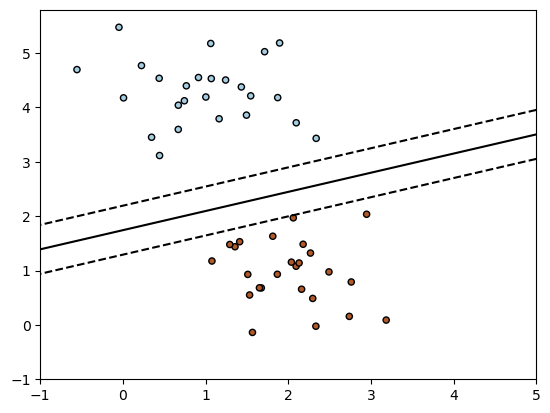

In [5]:
# Plot the maximum margin separating hyperplane within a two-class separable dataset using a linear Support Vector Machines classifier trained using SGD.
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.linear_model import SGDClassifier

# we create 50 separable points
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# fit the model
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)

clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolor="black", s=20)

plt.axis("tight")
plt.show()

/var/folders/09/r9ypp39n43xcrqb_590ldm_80000gn/T/ipykernel_71011/1534383074.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


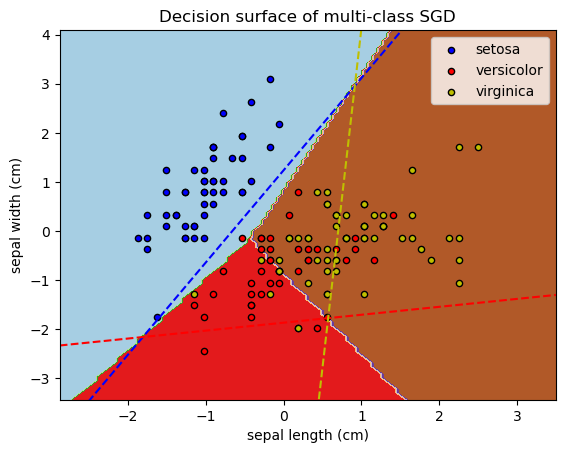

In [6]:
# Plot decision surface of multi-class SGD on iris dataset. The hyperplanes corresponding to the three one-versus-all (OVA) classifiers are represented by the dashed lines.
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import SGDClassifier

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could
# avoid this ugly slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target
colors = "bry"

# shuffle
idx = np.arange(X.shape[0])
np.random.seed(13)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

clf = SGDClassifier(alpha=0.001, max_iter=100).fit(X, y)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    xlabel=iris.feature_names[0],
    ylabel=iris.feature_names[1],
)
plt.axis("tight")

# Plot also the training points
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=color,
        label=iris.target_names[i],
        cmap=plt.cm.Paired,
        edgecolor="black",
        s=20,
    )
plt.title("Decision surface of multi-class SGD")
plt.axis("tight")

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_


def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)


for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)
plt.legend()
plt.show()

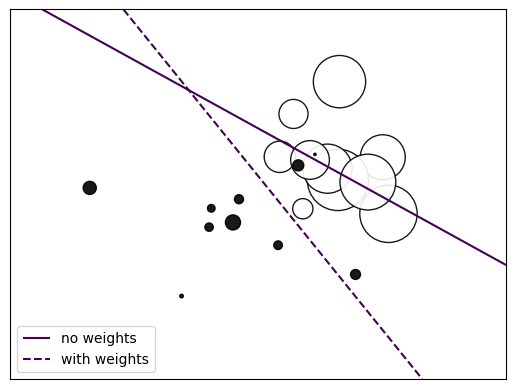

In [8]:
# Plot decision function of a weighted dataset, where the size of points is proportional to its weight.

import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model

# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight = 100 * np.abs(np.random.randn(20))
# and assign a bigger weight to the last 10 samples
sample_weight[:10] *= 10

# plot the weighted data points
xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))
fig, ax = plt.subplots()
ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    s=sample_weight,
    alpha=0.9,
    cmap=plt.cm.bone,
    edgecolor="black",
)

# fit the unweighted model
clf = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
no_weights = ax.contour(xx, yy, Z, levels=[0], linestyles=["solid"])

# fit the weighted model
clf = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y, sample_weight=sample_weight)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
samples_weights = ax.contour(xx, yy, Z, levels=[0], linestyles=["dashed"])

no_weights_handles, _ = no_weights.legend_elements()
weights_handles, _ = samples_weights.legend_elements()
ax.legend(
    [no_weights_handles[0], weights_handles[0]],
    ["no weights", "with weights"],
    loc="lower left",
)

ax.set(xticks=(), yticks=())
plt.show()

training SGD
training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG


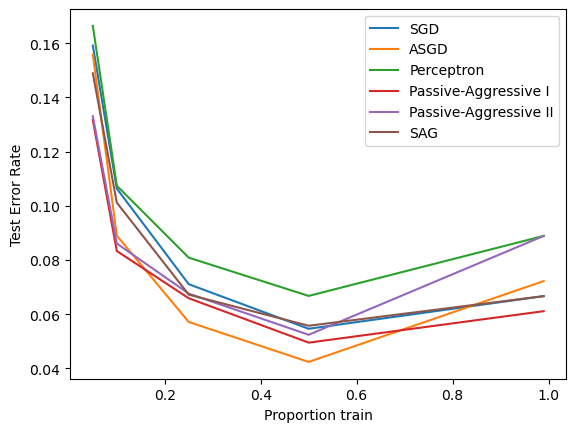

In [9]:
# An example showing how different online solvers perform on the hand-written digits dataset.
# Author: Rob Zinkov <rob at zinkov dot com>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    Perceptron,
    SGDClassifier,
)
from sklearn.model_selection import train_test_split

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
# Number of rounds to fit and evaluate an estimator.
rounds = 10
X, y = datasets.load_digits(return_X_y=True)

classifiers = [
    ("SGD", SGDClassifier(max_iter=110)),
    ("ASGD", SGDClassifier(max_iter=110, average=True)),
    ("Perceptron", Perceptron(max_iter=110)),
    (
        "Passive-Aggressive I",
        PassiveAggressiveClassifier(max_iter=110, loss="hinge", C=1.0, tol=1e-4),
    ),
    (
        "Passive-Aggressive II",
        PassiveAggressiveClassifier(
            max_iter=110, loss="squared_hinge", C=1.0, tol=1e-4
        ),
    ),
    (
        "SAG",
        LogisticRegression(max_iter=110, solver="sag", tol=1e-1, C=1.0e4 / X.shape[0]),
    ),
]

xx = 1.0 - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=i, random_state=rng
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

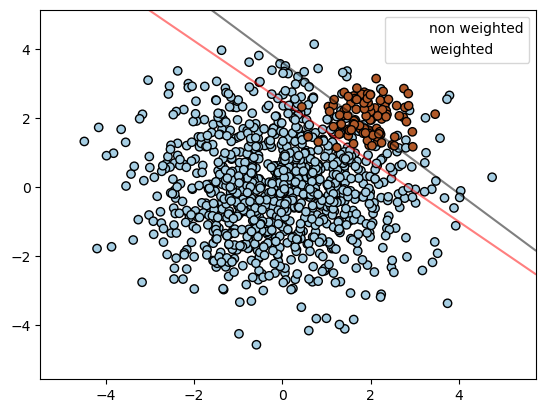

In [10]:
# Find the optimal separating hyperplane using an SVC for classes that are unbalanced.

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# we create two clusters of random points
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)

# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y)

# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={1: 10})
wclf.fit(X, y)

# plot the samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")

# plot the decision functions for both classifiers
ax = plt.gca()
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

# plot decision boundary and margins for weighted classes
wdisp = DecisionBoundaryDisplay.from_estimator(
    wclf,
    X,
    plot_method="contour",
    colors="r",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

plt.legend(
    [disp.surface_.collections[0], wdisp.surface_.collections[0]],
    ["non weighted", "weighted"],
    loc="upper right",
)
plt.show()